In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Metric
from tensorflow.keras import backend as K
import random
import copy
from tensorflow.keras import backend as K
import gc
import pickle

def prepare_data(df, max_words=10000, max_len=256):
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    df['message'] = df['message'].astype(str)
    tokenizer.fit_on_texts(df['message'])

    sequences = tokenizer.texts_to_sequences(df['message'])
    padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

    labels = df['sentiment'].map({-1: 0, 0: 1, 1: 2})
    categorical_labels = tf.keras.utils.to_categorical(labels)

    return padded_sequences, categorical_labels, tokenizer

def create_cnn_model(vocab_size, max_len=256, embedding_dim=768, num_channels=128, num_classes=3, dropout=0.4):

    model = models.Sequential([
        layers.Embedding(vocab_size, embedding_dim, input_length=max_len),

        layers.Conv1D(filters=num_channels, kernel_size=7, activation='relu', padding='valid'),

        layers.Conv1D(filters=num_channels, kernel_size=5, activation='relu', padding='valid'),

        layers.Conv1D(filters=num_channels, kernel_size=5, activation='relu', padding='valid'),

        layers.GlobalMaxPooling1D(),


        layers.Dropout(dropout),


        layers.Dense(128, activation='relu'),  
        layers.Dense(64, activation='relu'),  
        layers.Dropout(dropout),


        layers.Dense(num_classes, activation='softmax')
    ])

    return model

2025-07-11 10:09:25.082863: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 10:09:25.171625: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-11 10:09:25.211517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-11 10:09:25.305419: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-11 10:09:25.324880: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-11 10:09:25.434070: I tensorflow/core/platform/cpu_feature_gu

In [2]:
def evaluate_model(model, X_test, y_test, raw_texts_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    
    class_report = classification_report(y_test_classes, y_pred_classes, target_names=['0', '1', '2'],  digits=4)
    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

    print("\nTest Metrics:")
    print("-------------")
    print(class_report)
    print("\nConfusion Matrix:")
    print(conf_matrix)
    
    df_hasil = pd.DataFrame({
        'Teks Asli': raw_texts_test,
        'Label Aktual': y_test_classes,
        'Label Prediksi': y_pred_classes
    })

    df_hasil['Hasil'] = np.where(df_hasil['Label Aktual'] == df_hasil['Label Prediksi'], 'Benar', 'Salah')

    print("\n\n===== TABEL SAMPEL HASIL PREDIKSI PER DATA =====")
    print(df_hasil.head(15))
    
    return class_report, conf_matrix, df_hasil
    

In [3]:
max_words = 7500
max_len = 256
# batch_size = 32
# epochs = 2

df_train = pd.read_csv("df_train.csv")
df_train = df_train.dropna(subset=['message'])
df_test = pd.read_csv("df_test.csv")
df_test = df_test.dropna(subset=['message'])

X_train, y_train, tokenizer = prepare_data(df_train, max_words=max_words, max_len=max_len)



In [4]:
df_test['message'] = df_test['message'].astype(str)
sequences_test = tokenizer.texts_to_sequences(df_test['message'])  
X_test = pad_sequences(sequences_test, maxlen=max_len, padding='post', truncating='post')
labels_test = df_test['sentiment'].map({-1: 0, 0: 1, 1: 2})
y_test = tf.keras.utils.to_categorical(labels_test)
text = df_test['message']


In [6]:
lr = 1e-4
dropout = 0.1
batch_size = 16
epochs = 10
num_folds = 5

model = tf.keras.models.load_model('best_model_train_cnn_final.keras')

/home/azkaravindra/.conda/envs/KC/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


TypeError: <class 'keras.src.models.sequential.Sequential'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'sequential', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_input_shape': [None, 256], 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'embedding_input'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': [None, 256], 'input_dim': 7500, 'output_dim': 768, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 256}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [7], 'strides': [1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256, 768]}}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_1', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [5], 'strides': [1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 250, 128]}}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d_2', 'trainable': True, 'dtype': 'float32', 'filters': 128, 'kernel_size': [5], 'strides': [1], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 246, 128]}}, {'module': 'keras.layers', 'class_name': 'GlobalMaxPooling1D', 'config': {'name': 'global_max_pooling1d', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 242, 128]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_1', 'trainable': True, 'dtype': 'float32', 'units': 64, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_1', 'trainable': True, 'dtype': 'float32', 'rate': 0.1, 'noise_shape': None, 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_2', 'trainable': True, 'dtype': 'float32', 'units': 3, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 64]}}]}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}}.

Exception encountered: <class 'keras.src.layers.core.embedding.Embedding'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.layers', 'class_name': 'Embedding', 'config': {'name': 'embedding', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': [None, 256], 'input_dim': 7500, 'output_dim': 768, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 256}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}}.

Exception encountered: Error when deserializing class 'Embedding' using config={'name': 'embedding', 'trainable': True, 'dtype': 'float32', 'batch_input_shape': [None, 256], 'input_dim': 7500, 'output_dim': 768, 'embeddings_initializer': {'module': 'keras.initializers', 'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}, 'registered_name': None}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 256}.

Exception encountered: Unrecognized keyword arguments passed to Embedding: {'batch_input_shape': [None, 256]}

In [32]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 256, 768)       │     7,680,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 250, 256)       │     1,376,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 246, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 242, 256)       │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 256)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 768)            │       197,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 384)            │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │         1,155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,618,635 (116.80 MB)

 Trainable params: 10,206,211 (38.93 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,412,424 (77.87 MB)

In [29]:
class_report, conf_matrix, df_hasil = evaluate_model(model, X_test, y_test, text)

200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step

Test Metrics:
-------------
              precision    recall  f1-score   support

           0     0.3930    0.4838    0.4337       771
           1     0.3105    0.7628    0.4413      1501
           2     0.8302    0.3536    0.4960      4120

    accuracy                         0.4654      6392
   macro avg     0.5112    0.5334    0.4570      6392
weighted avg     0.6554    0.4654    0.4756      6392


Confusion Matrix:
[[ 373  296  102]
 [ 160 1145  196]
 [ 416 2247 1457]]


===== TABEL SAMPEL HASIL PREDIKSI PER DATA =====
                                            Teks Asli  Label Aktual  \
0   this global warming sure is getting out of con...             2   
1     pope francis to  fao  less talk  more action...             2   
2     great article for uk gardens  amp  climate c...             1   
3       the only candidate to mention climate chan...             2   
4     how will climate change actually affect you ...             1 

In [31]:
df_hasil.to_csv("df_hasil_cnn.csv")

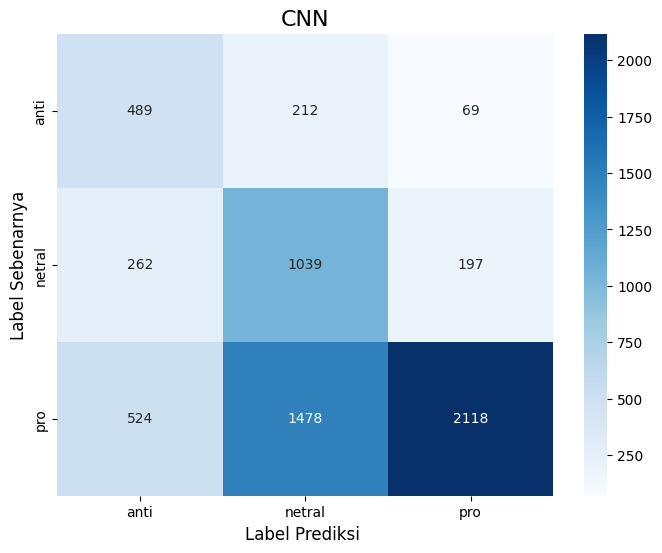

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

confusion_matrix_data = np.array([
    [489, 212, 69],
    [262, 1039, 197],
    [524, 1478, 2118]
])

class_names = ['anti', 'netral', 'pro']

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_data, 
            annot=True,       
            fmt='d',           
            cmap='Blues',      
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('CNN', fontsize=16)
plt.ylabel('Label Sebenarnya', fontsize=12)
plt.xlabel('Label Prediksi ', fontsize=12)
plt.show()
